In [1]:
# Dependencies
%matplotlib inline

import sqlalchemy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

from datetime import datetime, timedelta
from pandas import DataFrame
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect,func
from matplotlib import style
style.use('fivethirtyeight')

from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
# view the datasets you will be working with
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns_m = inspector.get_columns('measurement')
for row in columns_m:
    print(row['name'], row['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
measurement_df = engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()
measurement_masterdf = pd.DataFrame(measurement_df)
measurement_masterdf.head()

,0,1,2,3,4
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [10]:
columns_s = inspector.get_columns('station')
for row in columns_s:
    print(row['name'], row['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
station_df = engine.execute('SELECT * FROM station LIMIT 10').fetchall()
station_masterdf = pd.DataFrame(station_df)
station_masterdf.head()

,0,1,2,3,4,5
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12m = session.query(Measurement.date).order_by(Measurement.date.desc()).all()
last12_dataframe = pd.DataFrame(last_12m)
last12_dataframe.head()

,date
0,2017-08-23
1,2017-08-23
2,2017-08-23
3,2017-08-23
4,2017-08-22


In [13]:
# Calculate the date 1 year ago from the last data point in the database
# https://www.saltycrane.com/blog/2010/10/how-get-date-n-days-ago-python/
one_year_ago = dt.date(2017,8,23) - timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prec_scores = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23').\
            order_by(Measurement.date).all()
df = pd.DataFrame(prec_scores)
master_df = df.sort_values('date')
master_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


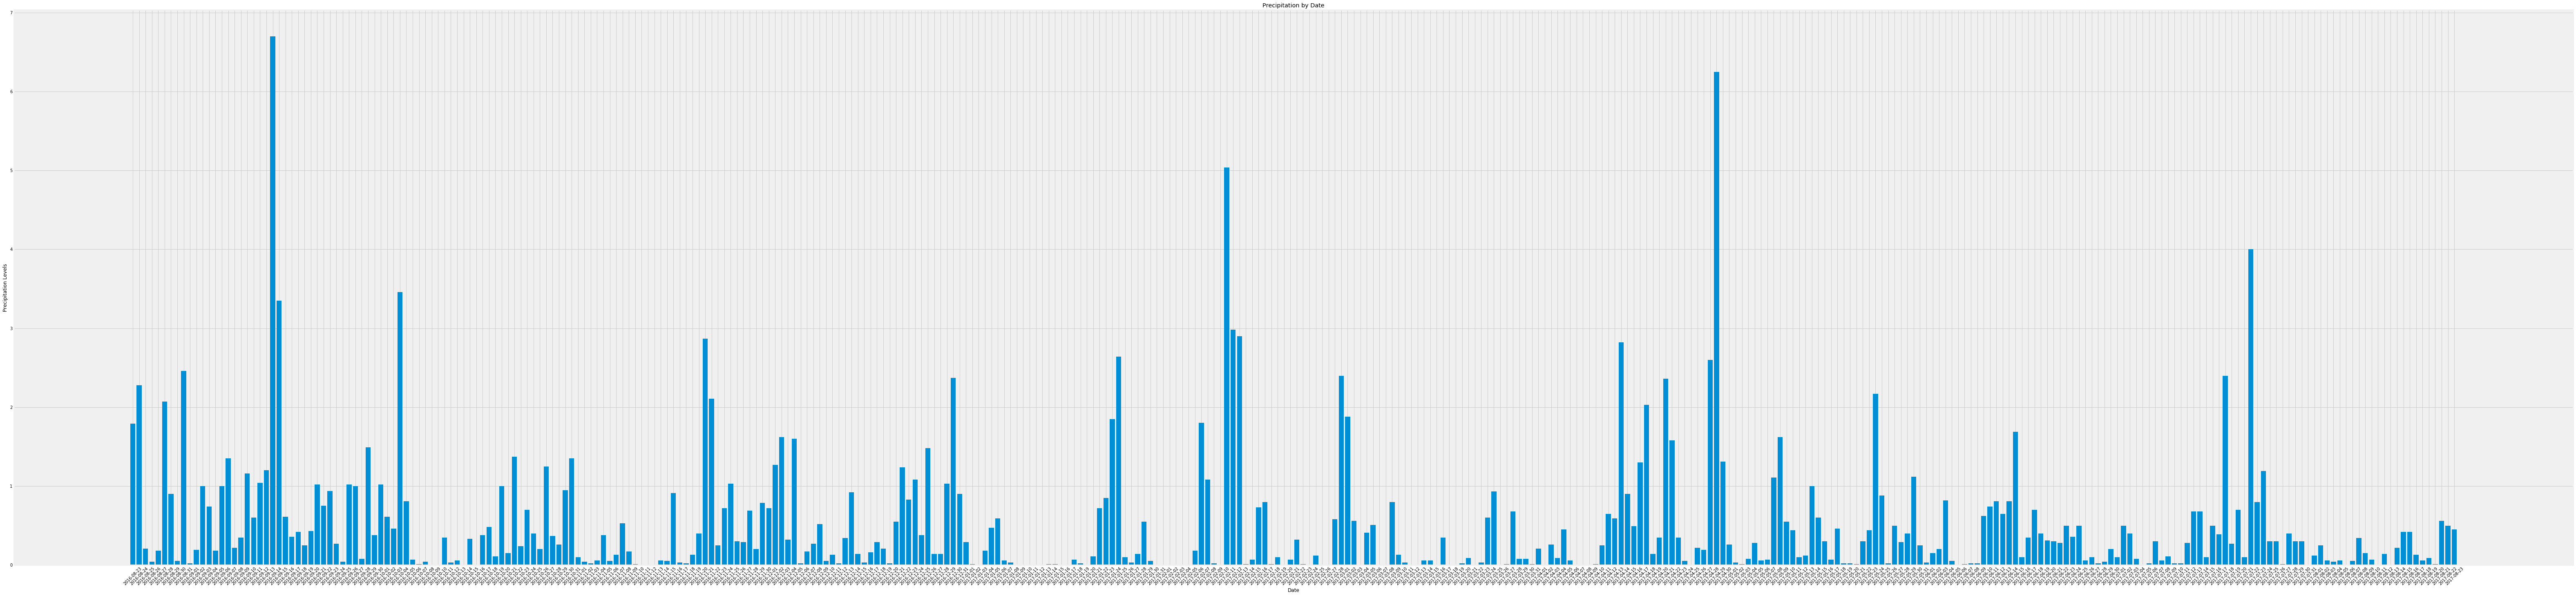

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
master_df.set_index(master_df["date"],inplace=True)

f, ax = plt.subplots(figsize=(100,25))
plt.bar(master_df["date"], master_df["prcp"])
plt.title("Precipitation by Date")
plt.ylabel("Precipitation Levels")
plt.xlabel("Date")
plt.xticks(rotation = 45)
#plt.tight_layout()
plt.grid(True)

plt.savefig("../Figures/precvsdate.png")

plt.show()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
master_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station.station).count()
number_of_stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
USC00519281_low = session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
USC00519281_low

[(54.0)]

In [20]:
USC00519281_high = session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
USC00519281_high

[(85.0)]

In [21]:
USC00519281_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
USC00519281_avg

[(71.66378066378067)]

In [22]:
# Just for fun: Here is the lowest, highest, and average of all stations
all_stations = [func.min(Measurement.tobs),
               func.max(Measurement.tobs),
               func.avg(Measurement.tobs)]

session.query(*all_stations).all()

[(53.0, 87.0, 73.09795396419437)]

In [23]:
# Choose the station with the highest number of temperature observations. ---> USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query2 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                                         filter(Measurement.station=='USC00519281').\
                                         filter(Measurement.date >= one_year_ago).\
                                         order_by(Measurement.date.desc()).all()
df = pd.DataFrame(query2)
df.head(10)

,station,date,tobs
0,USC00519281,2017-08-18,79.0
1,USC00519281,2017-08-17,76.0
2,USC00519281,2017-08-16,76.0
3,USC00519281,2017-08-15,77.0
4,USC00519281,2017-08-14,77.0
5,USC00519281,2017-08-13,77.0
6,USC00519281,2017-08-06,83.0
7,USC00519281,2017-08-05,82.0
8,USC00519281,2017-08-04,77.0
9,USC00519281,2017-07-31,76.0


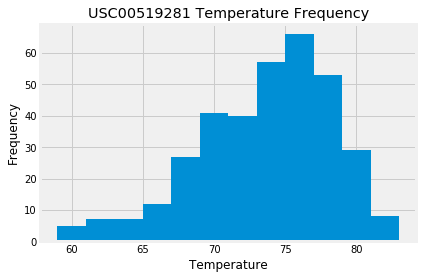

In [24]:
# Remaking the query to better fit the histogram
revised = session.query(Measurement.tobs).\
                            filter(Measurement.station=='USC00519281').\
                            filter(Measurement.date >= one_year_ago).\
                            order_by(Measurement.date.desc()).all()

tobs_df = pd.DataFrame(revised)

plt.hist(tobs_df["tobs"], bins=12)
plt.title("USC00519281 Temperature Frequency")
plt.ylabel("Frequency")
plt.xlabel("Temperature")

plt.savefig("../Figures/tempfrequency.png")

plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation = calc_temps('2017-07-01', '2017-07-08') # Vacation on 4th of July Week 
vacation

[(71.0, 78.04347826086956, 87.0)]

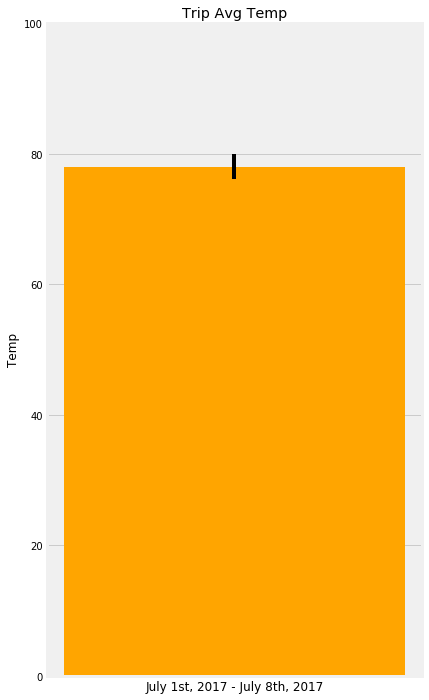

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

low = vacation[0][0]
low_por = vacation[0][1] - vacation[0][0]
high = vacation[0][2]
high_por = vacation[0][2] - vacation[0][1]

avg_temp = vacation[0][1]

plt.figure(figsize=(6,12))
plt.bar(0, avg_temp, 
        yerr=[high_por-low_por], 
        color='orange')

plt.xticks([])
plt.ylim([0, 100]) 
plt.title('Trip Avg Temp')
plt.ylabel('Temp')
plt.xlabel('July 1st, 2017 - July 8th, 2017')

plt.savefig("../Figures/tripavgtemp.png")

plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
vacation_start = '2017-06-01'
vacation_end = '2017-06-08'

challenge = session.query(Measurement.station, Measurement.date, Station.name,
                        Measurement.prcp, Station.latitude, 
                        Station.longitude, Station.elevation).\
                        group_by(Measurement.station).\
                        filter(Measurement.date >= vacation_start).\
                        filter(Measurement.date <= vacation_end).\
                        join(Station, Measurement.station == Station.station).\
                        order_by(Measurement.prcp.desc()).all()
challenge_df = pd.DataFrame(challenge)
challenge_df.head(100)

,station,date,name,prcp,latitude,longitude,elevation
0,USC00513117,2017-06-01,"KANEOHE 838.1, HI US",0.03,21.42340,-157.80150,14.6
1,USC00516128,2017-06-01,"MANOA LYON ARBO 785.2, HI US",0.01,21.33310,-157.80250,152.4
2,USC00519523,2017-06-01,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5
3,USC00519397,2017-06-01,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0
4,USC00519281,2017-06-01,"WAIHEE 837.5, HI US",0.00,21.45167,-157.84889,32.9
5,USC00514830,2017-06-01,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.00,21.52130,-157.83740,7.0
6,USC00517948,2017-06-02,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9
